In [2]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import tensorflow as tf
import keras
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import argparse
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn import tree
from keras.utils import plot_model


Using TensorFlow backend.


In [3]:
labels_kdd = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'attack_type', 'difficulty_level']


In [4]:
train = pd.read_csv('https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv')
test = pd.read_csv('https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.csv')

In [5]:
train.columns , test.columns = labels_kdd , labels_kdd

In [6]:
train = train.drop(columns =['protocol_type', 'service', 'flag'])
test = test.drop(columns =['protocol_type', 'service', 'flag'])

In [7]:
train_attacks, train_attacks_counts = np.unique(train['attack_type'], return_counts=True)
train_attacks

array(['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap',
       'ipsweep', 'land', 'loadmodule', 'multihop', 'neptune', 'nmap',
       'normal', 'perl', 'phf', 'pod', 'portsweep', 'rootkit', 'satan',
       'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster'],
      dtype=object)

In [8]:
test_attacks, test_attacks_counts = np.unique(test['attack_type'], return_counts=True)
test_attacks

array(['apache2', 'back', 'buffer_overflow', 'ftp_write', 'guess_passwd',
       'httptunnel', 'imap', 'ipsweep', 'land', 'loadmodule', 'mailbomb',
       'mscan', 'multihop', 'named', 'neptune', 'nmap', 'normal', 'perl',
       'phf', 'pod', 'portsweep', 'processtable', 'ps', 'rootkit',
       'saint', 'satan', 'sendmail', 'smurf', 'snmpgetattack',
       'snmpguess', 'sqlattack', 'teardrop', 'udpstorm', 'warezmaster',
       'worm', 'xlock', 'xsnoop', 'xterm'], dtype=object)

In [9]:
def under_sample(df, n=5000, random_state=0xFFFF):
    tmp2 = pd.DataFrame(columns=df.columns)
    attacks, counts = np.unique(df['attack_type'], return_counts=True)
    for each_attack in attacks:
        tmp = df[df['attack_type'] == each_attack]
        if each_attack == 'normal':
            n1= n*(len(attacks)-1)
            samples = tmp.sample(n =n1, random_state= random_state ,replace=True)
        else:
            samples = tmp.sample(n =n, random_state= random_state ,replace=True)
        
        tmp2 = tmp2.append(samples)
    tmp2 = tmp2.sample(frac=1, random_state=random_state)
    return tmp2
    
    

In [10]:
def remove_attacks(df, attack_types):
    tmp =[]
    for each in attack_types:
        tmp.append(df['attack_type'] != each)
    tmp = tuple(tmp)
    return np.logical_and.reduce(tmp)
        

In [13]:
def barplot_anomlaies(df1, train_attacks, test_attacks, save=None):
    normal = np.asarray(df1['attack_type']=='normal').sum()
    attack_types = np.setdiff1d(test_attacks,train_attacks)
    known_anomalies = remove_attacks(df1, attack_types=attack_types).sum()
    unknown_anomalies = np.logical_not(remove_attacks(df1, attack_types=attack_types)).sum()
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    langs = ['Normal', 'Known_Attacks', 'Unknown_Attacks']
    students = [normal,known_anomalies,unknown_anomalies]
    ax.bar(langs,students, width =0.4, color =['c','m', 'm'])
    #plt.xticks(range(3), langs, rotation=30) 
    plt.title('Distribution of Traffic over Test dataset')
    plt.ylabel('Number of Samples')
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight' )
    plt.show()
    pass
    
    
    

In [14]:
test = under_sample(test, 300)

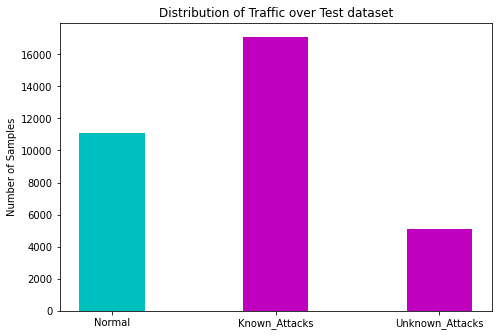

In [15]:
#barplot_anomlaies(test,train_attacks,test_attacks, save = './new/NSL_KDD/Traffic_distribution.png')
barplot_anomlaies(test,train_attacks,test_attacks)

In [16]:

#Train data
##train =
train_x = np.asarray( train.drop(columns = 'attack_type') )
test_x = np.asarray( test.drop(columns = 'attack_type') )

train_y = np.asarray(train['attack_type']) != 'normal'
test_y = np.asarray(test['attack_type']) != 'normal'

scaler = StandardScaler()
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

train_x_normal = train_x[~train_y]
train_y_normal = train_y[~train_y]

train_x_anomaly = train_x[train_y]


In [17]:
full_train_x = train_x


In [18]:
train_x, val_x, labels_condition, val_y = train_test_split(train_x, train_y, test_size=0.3, random_state=0xFFFF)

In [16]:
# train_x_normal = train_x[~labels_condition]
# train_y_normal = labels_condition[~labels_condition]

# train_x_anomaly = train_x[labels_condition]

In [17]:
# val_x_normal = val_x[~val_y]
# val_y_normal = val_y[~val_y]

# val_x_anomaly = val_x[val_y]

In [42]:
labels_condition =np.asarray(labels_condition).astype('int')
labels_condition[labels_condition==1] = 5

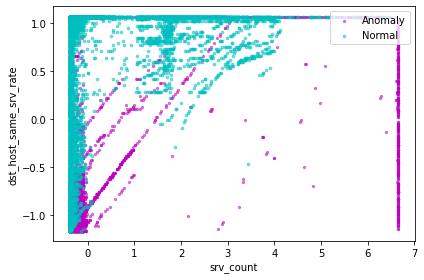

In [19]:
samples_for_scatter = 20000
xaxis = 20
yaxis = 30

plt.figure()
plt.scatter(train_x_anomaly[0:samples_for_scatter,xaxis] , train_x_anomaly[0:samples_for_scatter,yaxis] , c = 'm', label ='Anomaly', s=5, alpha = 0.5)
plt.scatter(train_x_normal[0:samples_for_scatter,xaxis] , train_x_normal[0:samples_for_scatter,yaxis] , c = 'c', label ='Normal', alpha = 0.5, s=7)
plt.xlabel(train.columns[xaxis])
plt.ylabel(train.columns[yaxis])
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('./new/NSL_KDD//dataset_features.png', dpi=200)
plt.show()


# Decision Trees

In [51]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(full_train_x, train_y)
predicted = clf.predict(test_x)

In [52]:
f1_score(test_y,predicted)

0.8547398287480368

# SVM

In [56]:
from sklearn.svm import SVC
clf = SVC()
clf = clf.fit(full_train_x,train_y)

In [57]:
predicted = clf.predict(test_x)

In [58]:
f1_score(test_y,predicted)

0.7812249692956694

# Autoencoder

In [20]:
original_dim = train_x.shape[1]
input_shape = (original_dim, )
intermediate_dim = int(original_dim/2)
batch_size = 50
latent_dim = int(original_dim/4)
epochs = 500

In [21]:
inputs = Input(shape=(original_dim,), name='encoder_input')
x = Dense(intermediate_dim, activation='relu',name='encoder_hidden')(inputs)
x = Dense(latent_dim, activation='relu',name='latent_space')(x)
x = Dense(intermediate_dim, activation='relu', name='decoder_hidden')(x)
outputs = Dense(original_dim,name='decoder_output')(x)
# instantiate encoder model
aae = Model(inputs, outputs, name='ae_mlp')

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

#vae.add_loss(vae_loss)
aae.compile(loss='mse', optimizer=optimizer)

In [25]:
aae.summary()

Model: "ae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 39)                0         
_________________________________________________________________
encoder_hidden (Dense)       (None, 19)                760       
_________________________________________________________________
latent_space (Dense)         (None, 9)                 180       
_________________________________________________________________
decoder_hidden (Dense)       (None, 19)                190       
_________________________________________________________________
decoder_output (Dense)       (None, 39)                780       
Total params: 1,910
Trainable params: 1,910
Non-trainable params: 0
_________________________________________________________________


In [27]:
with open('archi.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    aae.summary(print_fn=lambda x: fh.write(x + '\n'))

In [88]:
callbacks = [
    tf.keras.callbacks.EarlyStopping( monitor='val_loss',min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True),
]
history = aae.fit(train_x_normal , train_x_normal, epochs=500, batch_size= batch_size , callbacks= callbacks,verbose =1, validation_split=0.2)

Train on 53873 samples, validate on 13469 samples
Epoch 1/500
53873/53873 [==============================] - 3s 58us/step - loss: 0.9367 - val_loss: 0.6776
Epoch 2/500
53873/53873 [==============================] - 3s 52us/step - loss: 0.7996 - val_loss: 0.5796
Epoch 3/500
53873/53873 [==============================] - 3s 50us/step - loss: 0.7179 - val_loss: 0.5138
Epoch 4/500
53873/53873 [==============================] - 3s 51us/step - loss: 0.6572 - val_loss: 0.4544
Epoch 5/500
53873/53873 [==============================] - 3s 48us/step - loss: 0.5987 - val_loss: 0.3962
Epoch 6/500
53873/53873 [==============================] - 3s 54us/step - loss: 0.5460 - val_loss: 0.3451
Epoch 7/500
53873/53873 [==============================] - 3s 55us/step - loss: 0.5027 - val_loss: 0.3053
Epoch 8/500
53873/53873 [==============================] - 3s 52us/step - loss: 0.4711 - val_loss: 0.2814
Epoch 9/500
53873/53873 [==============================] - 3s 49us/step - loss: 0.4500 - val_loss: 0.2

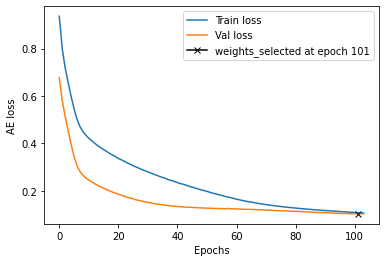

In [90]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label ='Train loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label ='Val loss')
plt.plot(len(history.history['val_loss'])-3,history.history['val_loss'][len(history.history['val_loss'])-3]  , marker='x', color='k', label='weights_selected at epoch {}'.format(len(history.history['val_loss'])-3))
plt.xlabel('Epochs')
plt.ylabel('AE loss')
plt.legend()
#plt.savefig('./new/NSL_KDD//ae_loss.png', dpi=200)

In [240]:
anomaly_detected_loss = np.mean((aae.predict(train_x_normal)- train_x_normal)**2, axis =-1)

In [241]:
threshold = np.quantile(anomaly_detected_loss, 0.95)
threshold

0.2680246845580657

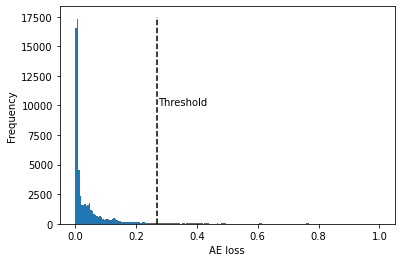

In [242]:
plt.hist(anomaly_detected_loss, bins =200, range=(0,1))
plt.vlines(threshold,0,17500, linestyles='dashed')
plt.text(threshold+0.005,10000, 'Threshold')
plt.xlabel('AE loss')
plt.ylabel('Frequency')
#plt.savefig('./new/NSL_KDD/ae_loss_hist.png')


In [243]:
anomaly_detected_loss = np.mean((aae.predict(test_x)- test_x)**2, axis =-1)



In [244]:
colors = test_y.astype('str')
colors[test_y] = 'm'
colors[~test_y] = 'c'

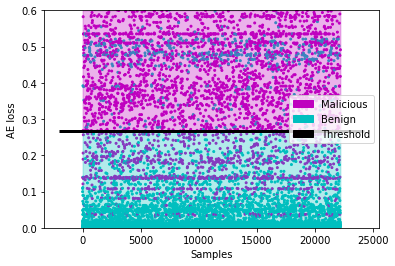

In [245]:

test_samples = len(test_x)
y_limit = (0,0.6)
alpha= 0.3

plt.scatter(range(test_samples), anomaly_detected_loss, c = colors, s = 4)
plt.hlines(threshold, -2000,test_samples+2000 ,'k', linewidths = 3, label= 'Threshold')

plt.fill_between(np.arange(test_samples), np.repeat(y_limit[0],test_samples), np.repeat(threshold, test_samples), color='c', alpha = alpha )
plt.fill_between(np.arange(test_samples), np.repeat(threshold,test_samples), np.repeat(y_limit[1], test_samples), color='m', alpha = alpha  )

plt.ylim(y_limit)
plt.ylabel('AE loss')
plt.xlabel('Samples')


red_patch = mpatches.Patch(color='m', label='Malicious')
blue_patch = mpatches.Patch(color='c', label='Benign')
threshold_ = mpatches.Patch(label = 'Threshold', color='k')

plt.legend(handles=[red_patch,blue_patch, threshold_])
#plt.savefig('./new/NSL_KDD/ae_partition.png', dpi=200)

In [246]:
anomaly_detected = anomaly_detected_loss > threshold
conf_matrix = confusion_matrix(test_y, anomaly_detected)
print(conf_matrix)
score =f1_score(test_y, anomaly_detected)
print('f1 score is ',score)
print('precision is ' , precision_score(test_y, anomaly_detected))
print('Recall is ', recall_score(test_y, anomaly_detected))

[[10078  1022]
 [ 1238  9862]]
f1 score is  0.8971979621542941
precision is  0.9061006982726939
Recall is  0.8884684684684685


# VAE

In [20]:
original_dim = train_x.shape[1]
input_shape = (original_dim, )
intermediate_dim = int(original_dim/2)
batch_size = 50
latent_dim = int(original_dim/4)
epochs = 500


In [21]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def train_loss(inputs,outputs):
    reconstruction_loss = K.mean(K.pow(inputs-outputs, 2), axis = -1)
    reconstruction_loss *= original_dim
    #tf.print(reconstruction_loss.shape)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    return vae_loss

def test_loss(inputss, outputss , mean, log_var):
    reconstruction_losses = np.mean((inputss-outputss)**2, axis = -1)
    reconstruction_losses *= original_dim
    kl_losses = 1 + log_var - np.square(mean) - np.exp(log_var)
    kl_losses = np.sum(kl_losses, axis = -1)
    kl_losses *= -0.5
    vae_losses = reconstruction_losses + kl_losses
    return vae_losses

def scheduler(epoch, learning_rate):
    if epoch < 20:
         return learning_rate
    else:
         return learning_rate * np.exp(-0.1)


In [22]:
# VAE model = encoder + decoder
# build encoder model

inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu' ,     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(inputs)
z_mean = Dense(latent_dim, name='z_mean',     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(x)
z_log_var = Dense(latent_dim, name='z_log_var',     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) , kernel_initializer='zeros', bias_initializer= 'zeros' )(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu',     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(latent_inputs)
outputs = Dense(original_dim ,    kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

#vae.add_loss(vae_loss)
vae.compile(optimizer=optimizer , loss=train_loss)


In [474]:
#train the model
callbacks = [
    tf.keras.callbacks.EarlyStopping( monitor='val_loss',min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True),
]
history = vae.fit(train_x_normal , train_x_normal, epochs=500, batch_size=  batch_size , callbacks= callbacks,verbose =1, validation_split=0.2)

Train on 53873 samples, validate on 13469 samples
Epoch 1/500
53873/53873 [==============================] - 4s 68us/step - loss: 43.5265 - val_loss: 30.6122
Epoch 2/500
53873/53873 [==============================] - 3s 62us/step - loss: 36.2071 - val_loss: 27.4873
Epoch 3/500
53873/53873 [==============================] - 4s 68us/step - loss: 33.8353 - val_loss: 25.9930
Epoch 4/500
53873/53873 [==============================] - 4s 65us/step - loss: 32.3701 - val_loss: 24.8373
Epoch 5/500
53873/53873 [==============================] - 3s 64us/step - loss: 31.1514 - val_loss: 23.7894
Epoch 6/500
53873/53873 [==============================] - 4s 66us/step - loss: 29.9629 - val_loss: 22.6291
Epoch 7/500
53873/53873 [==============================] - 3s 62us/step - loss: 28.8226 - val_loss: 21.6513
Epoch 8/500
53873/53873 [==============================] - 3s 64us/step - loss: 27.8248 - val_loss: 20.8595
Epoch 9/500
53873/53873 [==============================] - 3s 65us/step - loss: 26.976

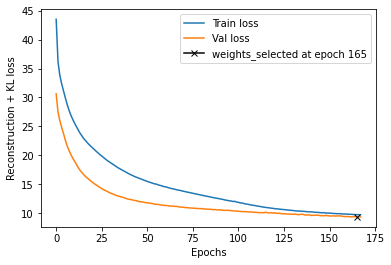

In [476]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label ='Train loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label ='Val loss')
plt.plot(len(history.history['val_loss'])-3,history.history['val_loss'][len(history.history['val_loss'])-3]  , marker='x', color='k', label='weights_selected at epoch {}'.format(len(history.history['val_loss'])-3))
plt.xlabel('Epochs')
plt.ylabel('Reconstruction + KL loss')
plt.legend()
#plt.savefig('./new/NSL_KDD//vae_loss.png', dpi=200)

In [257]:
estimated_vae_output_normal = vae.predict(train_x_normal , batch_size= batch_size)
mean_latent_normal, std_latent_normal, _ = encoder.predict(train_x_normal, batch_size= batch_size)

normal_train_loss = test_loss(train_x_normal,estimated_vae_output_normal, mean_latent_normal, std_latent_normal) 

In [258]:
threshold = np.quantile(normal_train_loss, 0.95)
threshold

20.168496592256112

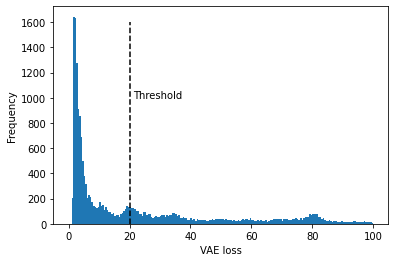

In [270]:
plt.hist(anomaly_detected_loss, bins =200, range=(0,100))
plt.vlines(threshold,0,1600, linestyles='dashed')
plt.text(threshold+1,1000, 'Threshold')
plt.xlabel('VAE loss')
plt.ylabel('Frequency')
#plt.savefig('./new/NSL_KDD/vae_loss_hist.png')

In [271]:
estimated_vae_output = vae.predict(test_x , batch_size= batch_size)
mean_latent_test, std_latent_test, _ = encoder.predict(test_x, batch_size= batch_size)

anomaly_detected_loss = test_loss(test_x,estimated_vae_output, mean_latent_test, std_latent_test)

In [272]:
colors = test_y.astype('str')
colors[test_y] = 'm'
colors[~test_y] = 'c'


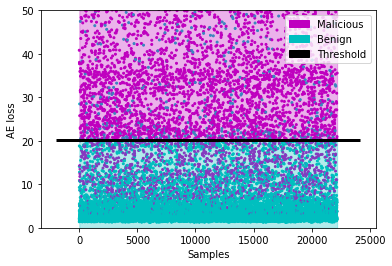

In [274]:
test_samples = len(test_x)
y_limit = (0,50)
alpha= 0.3

plt.scatter(range(test_samples), anomaly_detected_loss, c = colors, s = 4)
plt.hlines(threshold, -2000,test_samples+2000 ,'k', linewidths = 3, label= 'Threshold')

plt.fill_between(np.arange(test_samples), np.repeat(y_limit[0],test_samples), np.repeat(threshold, test_samples), color='c', alpha = alpha )
plt.fill_between(np.arange(test_samples), np.repeat(threshold,test_samples), np.repeat(y_limit[1], test_samples), color='m', alpha = alpha  )

plt.ylim(y_limit)
plt.ylabel('AE loss')
plt.xlabel('Samples')


red_patch = mpatches.Patch(color='m', label='Malicious')
blue_patch = mpatches.Patch(color='c', label='Benign')
threshold_ = mpatches.Patch(label = 'Threshold', color='k')

plt.legend(handles=[red_patch,blue_patch, threshold_], loc='upper right')
#plt.savefig('./new/NSL_KDD//vae_partition.png', dpi=200)

In [255]:
anomaly_detected = anomaly_detected_loss > threshold
conf_matrix = confusion_matrix(test_y, anomaly_detected)
print(conf_matrix)
score =f1_score(test_y, anomaly_detected)
print('f1 score is ',score)
print('precision is ' , precision_score(test_y, anomaly_detected))
print('Recall is ', recall_score(test_y, anomaly_detected))

[[10328   772]
 [ 1580  9520]]
f1 score is  0.8900523560209425
precision is  0.9249902837155072
Recall is  0.8576576576576577


In [275]:
normal_data_mean,normal_data_std, normal = encoder.predict(train_x_normal, batch_size=batch_size)
anomaly_data_mean, anomlay_data_std, anomaly = encoder.predict(train_x_anomaly, batch_size=batch_size)

In [290]:
dimensions_to_plot = 3
ndm =np.mean(normal_data_mean, axis =0)
tmp = np.abs(ndm).argsort()
ndm = ndm[tmp][0:dimensions_to_plot]
adm = np.mean(anomaly_data_mean, axis =0)
tmp1 = np.abs(adm).argsort()[::-1]
adm = adm[tmp1][0:dimensions_to_plot]

nds =np.mean(np.exp(normal_data_std), axis =0)[tmp][0:dimensions_to_plot]
ads = np.mean(np.exp(anomlay_data_std), axis =0)[tmp1][0:dimensions_to_plot]

red_patch = mpatches.Patch(color='m', label='Malicious')
blue_patch = mpatches.Patch(color='c', label='Benign')

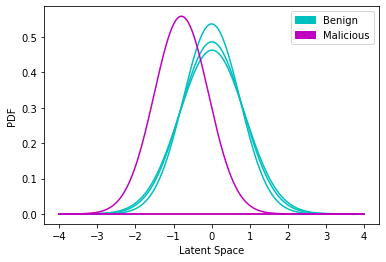

In [292]:
xs = np.arange(-4,4, 0.01)

plt.figure()

[plt.plot(xs,norm.pdf(xs,m,s), color='c') for m,s in zip(ndm, nds)]
[plt.plot(xs,norm.pdf(xs,m,s), color='m') for m,s in zip(adm, ads)]
#plt.ylim([0,1.5])
plt.xlabel('Latent Space')
plt.ylabel('PDF')

plt.legend(handles = [blue_patch, red_patch])
#plt.savefig('./new/NSL_KDD//vae_latent.png', dpi =200)

# EVAE

In [23]:
original_dim = train_x.shape[1]
input_shape = (original_dim, )
intermediate_dim = int(original_dim/2)
batch_size = 50
latent_dim = int(original_dim/4)
epochs = 500

In [24]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

def train_loss(inputs,outputs):
#    labels1 = inputs1[1]
#     inputs =inputs1[0]
#     outputs = outputs1
    #labels1 =tf.reshape(labels1, (11,-1))
#     normal_labels = tf.where(tf.equal(labels,False))
#     anomaly_labels = tf.where(tf.equal(labels,True))
    
    
#     inputs =tf.keras.backend.reshape (tf.keras.backend.gather(inputs1[0], normal_labels).re(-1,original_dim)
#     outputs = tf.keras.backend.gather(outputs1, normal_labels).reshape(-1,original_dim)
                                      
                                      
    reconstruction_loss = K.mean(K.pow(inputs-outputs, 2), axis = -1)
    reconstruction_loss *= original_dim
    #tf.print(reconstruction_loss.shape)
    kl_loss = 1 + z_log_var - K.square(z_mean-labels) - K.exp(z_log_var)
    kl_loss = K.mean(kl_loss, axis=-1)
    kl_loss *= -0.5
    normal_vae_loss = K.mean(reconstruction_loss + kl_loss)
    
#     inputs = tf.keras.backend.gather(inputs1[0], anomaly_labels)
#     outputs = tf.keras.backend.gather(outputs1, anomaly_labels)
#     reconstruction_loss = K.mean(K.pow(inputs-outputs, 2), axis = -1)
#     reconstruction_loss *= original_dim
#     #tf.print(reconstruction_loss.shape)
#     kl_loss = 1 + z_log_var - K.square(z_mean-10) - K.exp(z_log_var)
#     kl_loss = K.sum(kl_loss, axis=-1)
#     kl_loss *= -0.5
#     anomaly_vae_loss = 0.5 *K.mean(reconstruction_loss + kl_loss)
    
    return normal_vae_loss

def test_loss(inputss, outputss , mean, log_var):
    reconstruction_losses = np.mean((inputss-outputss)**2, axis = -1)
    reconstruction_losses *= original_dim
    kl_losses = 1 + log_var - np.square(mean) - np.exp(log_var)
    kl_losses = np.sum(kl_losses, axis = -1)
    kl_losses *= -0.5
    vae_losses = reconstruction_losses+ kl_losses
    return vae_losses

def scheduler(epoch, learning_rate):
    if epoch < 20:
         return learning_rate
    else:
         return learning_rate * np.exp(-0.1)


In [30]:
# VAE model = encoder + decoder
# build encoder model

inputs = Input(shape=input_shape, name='encoder_input')

labels = Input(shape = (1,), name='label_input')
#labels = K.tile(labels, (batc,))

x = Dense(intermediate_dim, activation='relu' ,     kernel_regularizer=regularizers.l2(1e-4), 
          bias_regularizer=regularizers.l2(1e-4), name='intermediate' )(inputs)
z_mean = Dense(latent_dim, name='z_mean',     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(x)
z_log_var = Dense(latent_dim, name='z_log_var',     kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) , kernel_initializer='zeros', bias_initializer= 'zeros' )(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu',     kernel_regularizer=regularizers.l2(1e-4), 
          bias_regularizer=regularizers.l2(1e-4), name='intermediate' )(latent_inputs)
outputs = Dense(original_dim ,    kernel_regularizer=regularizers.l2(1e-4),  bias_regularizer=regularizers.l2(1e-4) )(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model([inputs, labels], outputs, name='vae_mlp')

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

#vae.add_loss(vae_loss)
vae.compile(optimizer=optimizer , loss=train_loss)


In [31]:
with open('cvae_archi.txt','w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    encoder.summary(print_fn=lambda x: fh.write(x + '\n'))
    decoder.summary(print_fn=lambda x: fh.write(x + '\n'))
    #vae.summary(print_fn=lambda x: fh.write(x + '\n'))

In [56]:
#train the model
callbacks = [
    tf.keras.callbacks.EarlyStopping( monitor='val_loss',min_delta= 0.0001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True),
]
history = vae.fit([train_x,labels_condition] , train_x, epochs=150, batch_size= 50, verbose= 1, validation_data=([val_x,val_y], val_x))

Train on 88180 samples, validate on 37792 samples
Epoch 1/150
88180/88180 [==============================] - 5s 55us/step - loss: 44.2346 - val_loss: 29.1012
Epoch 2/150
88180/88180 [==============================] - 5s 55us/step - loss: 31.3422 - val_loss: 25.5766
Epoch 3/150
88180/88180 [==============================] - 5s 52us/step - loss: 27.1519 - val_loss: 24.4294
Epoch 4/150
88180/88180 [==============================] - 4s 49us/step - loss: 24.2898 - val_loss: 22.9908
Epoch 5/150
88180/88180 [==============================] - 5s 55us/step - loss: 22.2687 - val_loss: 21.5100
Epoch 6/150
88180/88180 [==============================] - 5s 52us/step - loss: 20.6916 - val_loss: 20.1888
Epoch 7/150
88180/88180 [==============================] - 5s 57us/step - loss: 19.3726 - val_loss: 19.1281
Epoch 8/150
88180/88180 [==============================] - 5s 59us/step - loss: 18.3360 - val_loss: 18.3698
Epoch 9/150
88180/88180 [==============================] - 5s 58us/step - loss: 17.602

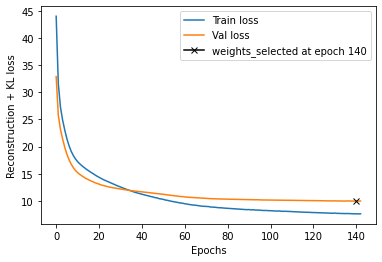

In [70]:
plt.plot(range(len(history.history['loss'])), history.history['loss'], label ='Train loss')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], label ='Val loss')
plt.plot(len(history.history['val_loss'])-3,history.history['val_loss'][len(history.history['val_loss'])-3]  , marker='x', color='k', label='weights_selected at epoch {}'.format(len(history.history['val_loss'])-3))
plt.xlabel('Epochs')
plt.ylabel('Reconstruction + KL loss')
plt.legend()
#plt.savefig('./new/NSL_KDD/evae_loss.png', dpi=200)

In [81]:
estimated_vae_output = vae.predict([val_x, np.zeros(len(val_x))] , batch_size= batch_size)
mean_latent_test, std_latent_test, _ = encoder.predict(val_x, batch_size= batch_size)

anomaly_detected_loss = test_loss(val_x,estimated_vae_output, mean_latent_test, std_latent_test)

In [82]:
xx = range(5,1000)
f1_scores=[]
for i in xx:
    anomaly_detected = anomaly_detected_loss > i
    f1_scores.append(f1_score(val_y.astype('bool'), anomaly_detected))

In [83]:
threshold = np.argmax(f1_scores)+xx[0]
threshold

51

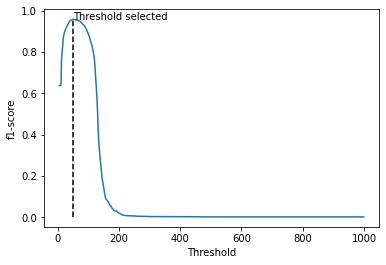

In [85]:
plt.plot(xx,f1_scores)
plt.xlabel('Threshold')
plt.ylabel('f1-score')
plt.text(threshold, np.max(f1_scores), 'Threshold selected')
plt.vlines(threshold,np.min(f1_scores),np.max(f1_scores), linestyles='dashed')
#plt.savefig('./new/NSL_KDD/evae_f1_scores.png', dpi=200)

In [60]:
estimated_vae_output = vae.predict([test_x, np.zeros(len(test_x))] , batch_size= batch_size)
mean_latent_test, std_latent_test, test_z = encoder.predict(test_x, batch_size= batch_size)

anomaly_detected_loss = test_loss(test_x,estimated_vae_output, mean_latent_test, std_latent_test)

In [87]:
threshold

19

In [61]:
anomaly_detected = anomaly_detected_loss > threshold

In [62]:
score =f1_score(test_y, anomaly_detected)

print('f1 score is ',score)
print('precision is ' , precision_score(test_y, anomaly_detected))
print('Recall is ', recall_score(test_y, anomaly_detected))
print(confusion_matrix(test_y, anomaly_detected))

f1 score is  0.8892679328784805
precision is  0.9105929003021148
Recall is  0.8689189189189189
[[10153   947]
 [ 1455  9645]]


In [63]:
colors = test_y.astype('str')
colors[test_y] = 'm'
colors[~test_y] = 'c'


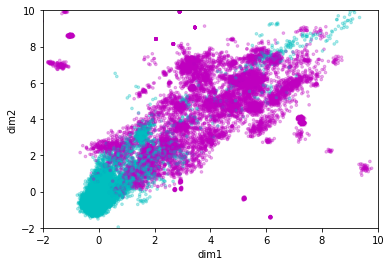

In [78]:
dims = np.argsort(test_z.std(axis=0))

plt.scatter(test_z[:,dims[0]], test_z[:,dims[1]], s=7, c=colors, alpha =0.3)
plt.xlim(-2,10)
plt.ylim(-2,10)
plt.xlabel('dim1')
plt.ylabel('dim2')
#plt.savefig('./new/NSL_KDD/evae_latent_samples.png', dpi=200)

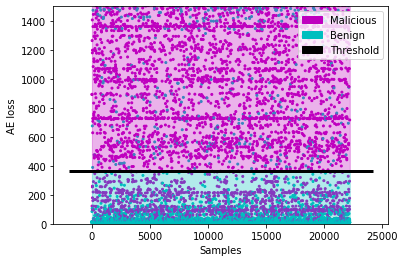

In [574]:
test_samples = len(test_x)
y_limit = (0,1500)
alpha= 0.3

plt.scatter(range(test_samples), anomaly_detected_loss, c = colors, s = 4)
plt.hlines(threshold, -2000,test_samples+2000 ,'k', linewidths = 3, label= 'Threshold')

plt.fill_between(np.arange(test_samples), np.repeat(y_limit[0],test_samples), np.repeat(threshold, test_samples), color='c', alpha = alpha )
plt.fill_between(np.arange(test_samples), np.repeat(threshold,test_samples), np.repeat(y_limit[1], test_samples), color='m', alpha = alpha  )

plt.ylim(y_limit)
plt.ylabel('AE loss')
plt.xlabel('Samples')


red_patch = mpatches.Patch(color='m', label='Malicious')
blue_patch = mpatches.Patch(color='c', label='Benign')
threshold_ = mpatches.Patch(label = 'Threshold', color='k')

plt.legend(handles=[red_patch,blue_patch, threshold_], loc='upper right')
#plt.savefig('./new/NSL_KDD/evae_partition.png', dpi=200)

In [575]:
normal_data_mean,normal_data_std, normal = encoder.predict(train_x_normal, batch_size=batch_size)
anomaly_data_mean, anomlay_data_std, anomaly = encoder.predict(train_x_anomaly, batch_size=batch_size)

In [576]:
dimensions_to_plot = 3
ndm =np.mean(normal_data_mean, axis =0)
tmp = np.abs(ndm).argsort()
ndm = ndm[tmp][0:dimensions_to_plot]
adm = np.mean(anomaly_data_mean, axis =0)
tmp1 = np.abs(adm).argsort()[::-1]
adm = adm[tmp1][0:dimensions_to_plot]

nds =np.mean(np.exp(normal_data_std), axis =0)[tmp][0:dimensions_to_plot]
ads = np.mean(np.exp(anomlay_data_std), axis =0)[tmp1][0:dimensions_to_plot]

red_patch = mpatches.Patch(color='m', label='Malicious')
blue_patch = mpatches.Patch(color='c', label='Benign')

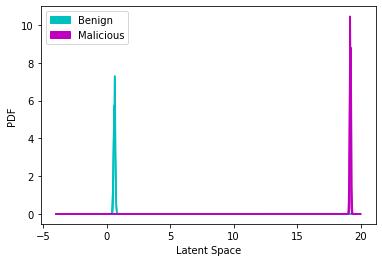

In [578]:
xs = np.arange(-4,20, 0.01)

plt.figure()

[plt.plot(xs,norm.pdf(xs,m,s), color='c') for m,s in zip(ndm, nds)]
[plt.plot(xs,norm.pdf(xs,m,s), color='m') for m,s in zip(adm, ads)]
#plt.ylim([0,1.5])
plt.xlabel('Latent Space')
plt.ylabel('PDF')

plt.legend(handles = [blue_patch, red_patch])
#plt.savefig('./new/NSL_KDD/evae_latent.png', dpi =200)